## Using Twitter for Disaster Alerts 

### Imports

In [1]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# imports for tweet cleaning
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# imports for modeling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score
import warnings

In [2]:
df = pd.read_csv('./data/train.csv')

In [58]:
df.shape

(7613, 5)

In [3]:
df.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


### Tweet Cleaning, and Preprocessing

First I set up the classifer variable and the variable representing the corpus of tweets. 

In [4]:
# Set up classifier output variable
y = df['target']

# Setting up corpus by first removing all website links from tweets
X = df['text'].str.replace('http\S+|www.\S+', ' ', case = False)

Within the set up of the corpus, `X` variable, I have already cleaned the tweets of any sort of text that resembles a website link. This will leave the tweets with hashtags, numbers, and mixed cases but the text will be readable by human eyes so as to be able to read through tweets and verify the classification indicated in the `target` column per tweet.<br>  

The following function will clean the tweets further by removing non-letters, stopwords, and lowercasing all letters in the tweet. The function will also give me the option to lemmatize or stem the remaining words in the tweets. 

In [5]:
def tweet_cleaning(raw, lemmat = False, stem = False):
    # 1. Remove non-letters.
    letters_only = re.sub('[^a-zA-Z]', ' ', raw)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. Join all the stopwords as a string with " ", remove "'" from the stopwords and split it as a list.
    stops = " ".join(stopwords.words('english')).replace("'", "").split()
    
    # 4. Remove stopwords.
    meaningful_words = [w for w in words if not w in stops]
    
    # lemmatizing corpus
    if lemmat == True and stem == False:
        lemmatizer = WordNetLemmatizer()
        lemmatizing = [lemmatizer.lemmatize(word) for word in meaningful_words]
        return(" ".join(lemmatizing))
    # Stemming corpus
    elif lemmat == False and stem == True:
        p_stemmer = PorterStemmer()
        stemming = [p_stemmer.stem(word) for word in meaningful_words]
        return(" ".join(stemming))
    # Simple cleaning of corpus
    else:
        return(" ".join(meaningful_words))

Stemming the corpus loses the contextual interpretability that might be necessary for visualization when it comes to choosing which words to use in the modeling process. This is evident in the stemmed corpus below where words like "earthquake", "wildfire" and "evacuation" are shortened down to "earthquak" and "wildfir" and "evacu". In the case of "earthquake" and "wildfire" it is still relativelly easy to guess what the original word was but with a stemmed word like "evacu", the original word could have been "evacuation", "evacuate", "evacuating", and so on. When using data such as a tweet, where slang and subtly mispelled words can change the meaning of a tweet, it is important to retain as much of the properly spelled words as possible for the sake of interpretibility of the model when classifying between a disaster and non disaster related tweet.

In [40]:
X_stem = df['text'].str.replace('http\S+|www.\S+', ' ', case = False).copy()
X_stem = X_stem.apply(lambda tweet: tweet_cleaning(tweet, stem = True))

In [41]:
X_stem.head()

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3          peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
Name: text, dtype: object

In order to maintain the readability of the tweets, the lemmatizer will be used instead of the stemmer.

In [6]:
X = X.apply(lambda tweet: tweet_cleaning(tweet, lemmat = True))

In [7]:
X.head()

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3    people receive wildfire evacuation order calif...
4    got sent photo ruby alaska smoke wildfire pour...
Name: text, dtype: object

### EDA

With general text cleaning and processing done, I checked the classification balance of the tweets. While the negative class (non-disaster related tweets) is larger, there is not a significance class imbalance that will require oversampling. However, an adaboost model may be useful to run later for validation purposes just in case.  

0    0.57034
1    0.42966
Name: target, dtype: float64

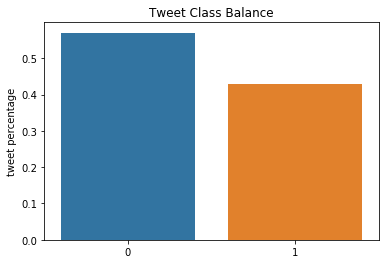

In [12]:
class_balance = y.value_counts(normalize = True)
sns.barplot(class_balance.index, class_balance)
plt.gca().set_ylabel('tweet percentage')
plt.gca().set_title('Tweet Class Balance')
class_balance

The corpus will be processed through a CountVectorizer and a TfidfVectorizer in order to run classification models based off the term frequency as well as the term frequency inverse document frequency of all words in the corpus. The CountVectorizer will model based purely on how often a word appears in the corpus but the TfidfVectorizer will take into account the number of times a word appears in a tweet but also the number of tweets that a word apears in. This will be more useful in the classification model because it will essentially rank a word based off its contextual importance. Words that are high in occurence such as "like" or "the" will show higher weight in the model in a count vectorized training set. However, a tfidf vectorized training set will rank words by term frequency but put higher weight on words with lower document frequency on the assumption that those words will have higher contextual importance. Both the CountVectorizer and the TfidfVectorizer will be used for comparison. 

In [8]:
#Instantiate Vectorizers
cvec = CountVectorizer()
tfidf = TfidfVectorizer()

# Train/Test Split
X_train,X_test, y_train, y_test = train_test_split(X, y, 
                                                   stratify = y, # maintains the class balance 
                                                   random_state = 42)

In [9]:
# Count Vectorized Corpus
X_cvec = pd.DataFrame(cvec.fit_transform(X).toarray(),
                      columns = cvec.get_feature_names())
# TfidfVectorized Corpus
X_tfidf = pd.DataFrame(tfidf.fit_transform(X).toarray(),
                       columns = tfidf.get_feature_names())
# CountVectorized train/test split
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).toarray(), 
                       columns = cvec.get_feature_names())
X_test_cvec = pd.DataFrame(cvec.transform(X_test).toarray(),
                      columns = cvec.get_feature_names())

# TfidfVectorized train/test split
X_train_tfidf = pd.DataFrame(tfidf.fit_transform(X_train).toarray(), 
                       columns = tfidf.get_feature_names())
X_test_tfidf = pd.DataFrame(tfidf.transform(X_test).toarray(),
                      columns = tfidf.get_feature_names())

In [10]:
X_train_cvec.head()

,aa,aaaaaaallll,aaaaaand,aaarrrgghhh,aace,aal,aan,aannnnd,aar,aaronthefm,...,zojadelin,zombie,zone,zoom,zouma,zourryart,zrnf,zumiez,zurich,zxathetis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X_train_tfidf.head()

,aa,aaaaaaallll,aaaaaand,aaarrrgghhh,aace,aal,aan,aannnnd,aar,aaronthefm,...,zojadelin,zombie,zone,zoom,zouma,zourryart,zrnf,zumiez,zurich,zxathetis
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
tfidf_vis= pd.merge(X_tfidf,df['target'], left_index= True, right_index= True)
cvec_vis = pd.merge(X_cvec, df['target'], left_index= True, right_index = True)
cvec_vis.head()

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aace,aal,aamir,aan,aannnnd,...,zoom,zotar,zouma,zourryart,zrnf,zumiez,zurich,zxathetis,zzzz,target_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


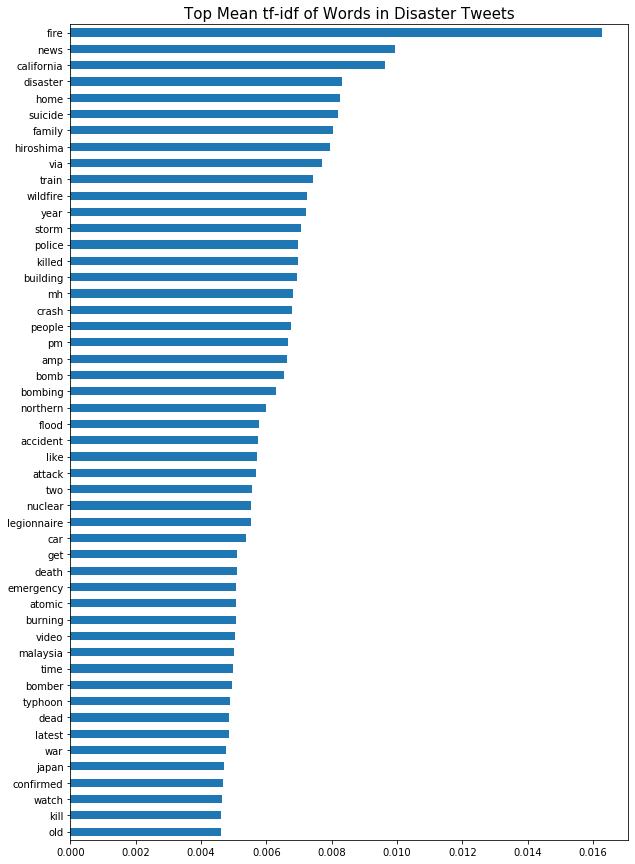

In [43]:
tfidf_vis.loc[tfidf_vis['target_y']==1].drop(columns = 'target_y').mean().sort_values(ascending= True).tail(50).plot(kind = 'barh', figsize = (10,15));
plt.yticks(fontsize = 10);
plt.xticks(fontsize = 10);
plt.title('Top Mean tf-idf of Words in Disaster Tweets', fontsize = 15);

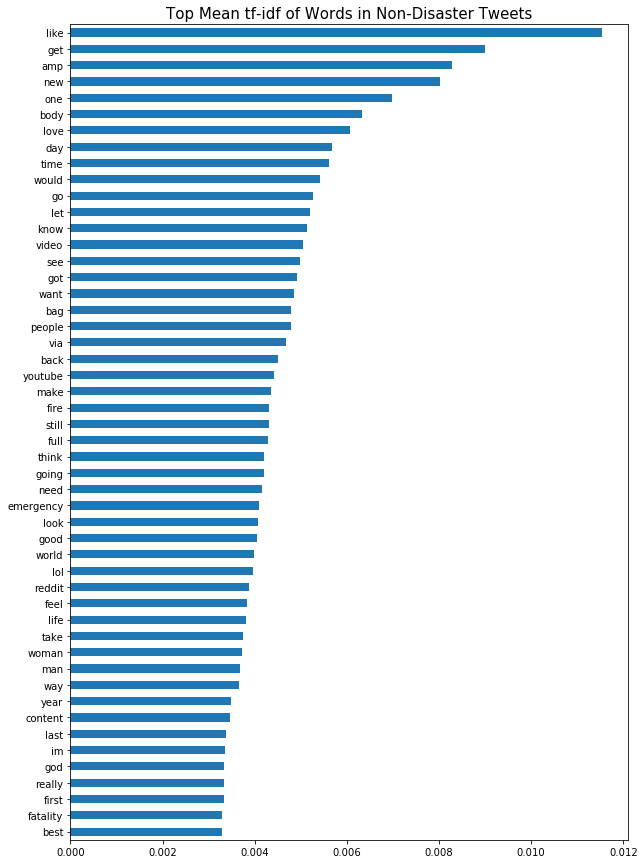

In [44]:
tfidf_vis.loc[tfidf_vis['target_y']==0].drop(columns = 'target_y').mean().sort_values(ascending= True).tail(50).plot(kind = 'barh', figsize = (10,15));
plt.yticks(fontsize = 10);
plt.xticks(fontsize = 10);
plt.title('Top Mean tf-idf of Words in Non-Disaster Tweets', fontsize = 15);

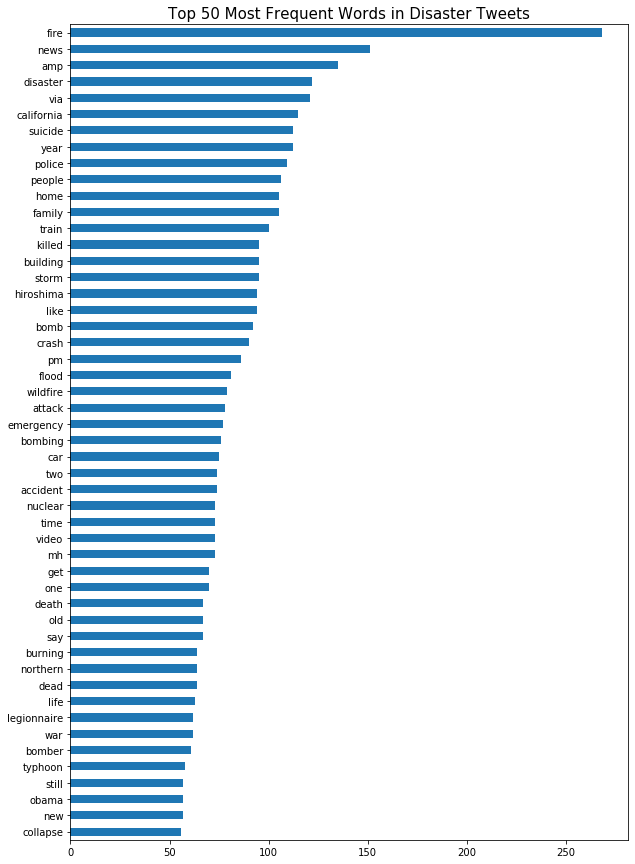

In [45]:
cvec_vis.loc[cvec_vis['target_y']==1].drop(columns = 'target_y').sum().sort_values(ascending= True).tail(50).plot(kind = 'barh', figsize = (10,15));
plt.yticks(fontsize = 10);
plt.xticks(fontsize = 10);
plt.title('Top 50 Most Frequent Words in Disaster Tweets', fontsize = 15);

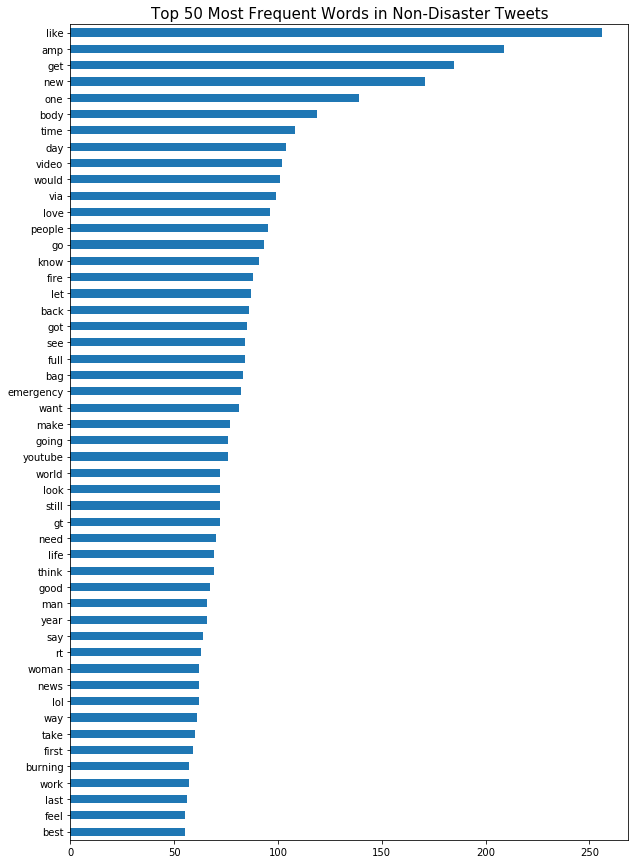

In [46]:
cvec_vis.loc[cvec_vis['target_y']==0].drop(columns = 'target_y').sum().sort_values(ascending= True).tail(50).plot(kind = 'barh', figsize = (10,15));
plt.yticks(fontsize = 10);
plt.xticks(fontsize = 10);
plt.title('Top 50 Most Frequent Words in Non-Disaster Tweets', fontsize = 15);

### Modeling and Validation

In [18]:
# Accuracy for baseline model
baseline_acc = round(df['target'].value_counts(normalize = True)[0],2)
baseline_acc

0.57

In [19]:
# Baseline predictions for model that always predicts the positive class
baseline_preds = y.map({0:1,1:1}) 

# f-measure for baseline model
baseline_f1 = round(f1_score(y, baseline_preds),3)
print(f'baseline f measure: {baseline_f1}')

baseline f measure: 0.601


In [20]:
baseline_preds.value_counts(dropna = False)

1    7613
Name: target, dtype: int64

In [21]:
# Instantiating Pipelines for potential models
pipe_rf_cvec = Pipeline([('cvec',CountVectorizer()),                         
                         ('rf', RandomForestClassifier(n_estimators= 100))])
pipe_rf_tfidf = Pipeline([('tfidf', TfidfVectorizer()),                          
                          ('rf', RandomForestClassifier(n_estimators=100))])
pipe_ada_cvec = Pipeline([('cvec', CountVectorizer()),                          
                          ('ada', AdaBoostClassifier(n_estimators=100))])
pipe_ada_tfidf = Pipeline([('tfidf', TfidfVectorizer()),                           
                           ('ada', AdaBoostClassifier(n_estimators = 100))])
pipe_svc_cvec = Pipeline([('cvec', CountVectorizer()),
                           ('svc', SVC(gamma = 'scale',
                                       random_state = 42))])
pipe_svc_tfidf = Pipeline([('tfidf', TfidfVectorizer()),                    
                           ('svc', SVC(gamma = 'scale',
                                       random_state = 42))])
# Instantiating vectorizer parameters
cvec_params = {'cvec__stop_words':[None,'english'],
               'cvec__ngram_range':[(1,1),(1,2),(1,3)]}
tfidf_params = {'tfidf__stop_words': [None, 'english'],
                'tfidf__ngram_range': [(1,1),(1,2),(1,3)]}

# Random Forest GridSearches
grid_rf_cvec = GridSearchCV(pipe_rf_cvec, cvec_params,cv = 5)
grid_rf_tfidf = GridSearchCV(pipe_rf_tfidf, tfidf_params, cv = 5)


# Adaboost GridSearches
grid_ada_cvec = GridSearchCV(pipe_ada_cvec, cvec_params, cv = 5)
grid_ada_tfidf = GridSearchCV(pipe_ada_tfidf, tfidf_params, cv = 5)

# SVC GridSearch
grid_svc_cvec = GridSearchCV(pipe_svc_cvec,cvec_params, cv = 5)
grid_svc_tfidf = GridSearchCV(pipe_svc_tfidf, tfidf_params, cv = 5)

In [22]:
models = [grid_rf_cvec, grid_rf_tfidf, grid_ada_cvec, 
          grid_ada_tfidf, grid_svc_cvec, grid_svc_tfidf]
model_names = ['CountVectorized Random Forest','TFIDF Random Forest',
               'CountVectorized Adaboost','TFIDF Adaboost', 'CountVectorized SVC', 'TFIDF SVC']
predictions = ['cvec_rf_pred', 'tfidf_rf_pred', 'cvec_adaboost_pred', 'tfidf_adaboost_pred',
               'cvec_svc_pred', 'tfidf_svc_pred']

# loops through each gridsearch and prints out accuracy scores and parameters for the best estimator
for (model, model_name, pred) in zip(models, model_names, predictions):
    model.fit(X_train,y_train)
    pred = model.best_estimator_.predict(X_test)

    tn,fp,fn,tp = confusion_matrix(y_test, pred).ravel()
    f_measure = f1_score(y_test, pred)
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    acc = (tp+tn)/(tn+tp+fp+fn)
    false_pos_rate = fn/(tp+fn)
    print(f'{model_name}')
    print(f'best params: {model.best_params_}')
    print(f'best estimator train accuracy: {model.best_estimator_.score(X_train,y_train)}')
    print(f'best estimator test accuracy: {model.best_estimator_.score(X_test,y_test)}')
    
    print(f'sensitivity: {sens}, specificity: {spec}')
   
    print(f'f1_score: {f_measure}')
    print()
    
print(f'baseline accuracy:{baseline_acc}')
print(f'baseline f measure: {baseline_f1}')

CountVectorized Random Forest
best params: {'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}
best estimator train accuracy: 0.9887896304081275
best estimator test accuracy: 0.8019957983193278
sensitivity: 0.6772616136919315, specificity: 0.8959484346224678
f1_score: 0.7461279461279461

TFIDF Random Forest
best params: {'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
best estimator train accuracy: 0.9889647924330005
best estimator test accuracy: 0.7962184873949579
sensitivity: 0.6711491442542787, specificity: 0.8904235727440147
f1_score: 0.7388963660834456

CountVectorized Adaboost
best params: {'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
best estimator train accuracy: 0.7880539499036608
best estimator test accuracy: 0.7725840336134454
sensitivity: 0.6625916870415648, specificity: 0.8554327808471455
f1_score: 0.7145682267633487

TFIDF Adaboost
best params: {'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': None}
best estimator train accuracy: 0.8013662637

In [23]:
grid_svc_tfidf.best_estimator_.score(X_test,y_test)


0.8130252100840336

In [24]:
pred = grid_svc_tfidf.best_estimator_.predict(X_test)
tn,fp,fn,tp = confusion_matrix(y_test, pred).ravel()
acc = (tp+tn)/(tn+tp+fp+fn)
acc

0.8130252100840336

In [36]:
df['keyword'].value_counts(dropna = False).head(20)

NaN            61
fatalities     45
deluge         42
armageddon     42
sinking        41
harm           41
body%20bags    41
damage         41
collided       40
windstorm      40
outbreak       40
twister        40
evacuate       40
siren          40
fear           40
flames         39
earthquake     39
weapon         39
hellfire       39
sinkhole       39
Name: keyword, dtype: int64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [25]:
# predictions = ['cvec_rf_pred', 'tfidf_rf_pred', 'cvec_adaboost_pred', 'tfidf_adaboost_pred', 'cvec_svc_pred', 'tfidf_svc_pred']
# for model, pred, model_name in zip(models, predictions, model_names):
    
#     pred = model.best_estimator_.predict(X_test)

#     tn,fp,fn,tp = confusion_matrix(y_test, pred).ravel()
#     f_measure = f1_score(y_test, pred)
#     sens = tp/(tp+fn)
#     spec = tn/(tn+fp)
#     acc = (tp+tn)/(tn+tp+fp+fn)
#     false_pos_rate = fn/(tp+fn)
#     print(f'{model_name}')
#     print(f'false pos:{fp}, false neg:{fn}')
#     print(f'true pos: {tp}, true neg: {tn}')
#     print(f'sensitivity: {sens}, specificity: {spec}')
#     print(f'false_neg_rate: {false_pos_rate}')
#     print(f'f1_score: {f_measure}')
#     print('')
# print(f'baseline: {baseline}')